In [1]:
from GEOparse import get_GEO
import numpy as np
import pandas as pd


In [34]:
import GEOparse
import pandas as pd

# Load GSE96058
gse = GEOparse.get_GEO("GSE96058", destdir=".")

# Extract sample metadata
sample_info = []
for gsm_name, gsm in gse.gsms.items():
    label = gsm.metadata.get("characteristics_ch1", ["unknown"])[0]
    sample_info.append((gsm_name, label))

sample_df = pd.DataFrame(sample_info, columns=["sample_id", "label"])
sample_df['label'] = sample_df['label'].str.replace(".*: ", "", regex=True)

# Supplementary files (check for expression matrix)
supp_files = gse.metadata.get('supplementary_file', [])

print("Supplementary files available:")
for f in supp_files:
    print(f)

30-May-2025 22:16:24 DEBUG utils - Directory . already exists. Skipping.
30-May-2025 22:16:24 INFO GEOparse - File already exist: using local version.
30-May-2025 22:16:24 INFO GEOparse - Parsing .\GSE96058_family.soft.gz: 
30-May-2025 22:16:24 DEBUG GEOparse - DATABASE: GeoMiame
30-May-2025 22:16:24 DEBUG GEOparse - SERIES: GSE96058
30-May-2025 22:16:24 DEBUG GEOparse - PLATFORM: GPL11154
30-May-2025 22:16:24 DEBUG GEOparse - PLATFORM: GPL18573
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528079
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528080
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528081
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528082
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528083
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528084
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528085
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528086
30-May-2025 22:16:24 DEBUG GEOparse - SAMPLE: GSM2528087
30-May-2025 22:16:24 DEBUG GEOparse -

Supplementary files available:
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE96nnn/GSE96058/suppl/GSE96058_UCSC_hg38_knownGenes_22sep2014.gtf.gz
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE96nnn/GSE96058/suppl/GSE96058_gene_expression_3273_samples_and_136_replicates_transformed.csv.gz
ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE96nnn/GSE96058/suppl/GSE96058_transcript_expression_3273_samples_and_136_replicates.csv.gz


In [38]:
import pandas as pd

expr_df = pd.read_csv("GSE96058_transcript_expression_3273_samples_and_136_replicates.csv.gz", compression='gzip', index_col=0)
print(expr_df.shape)
print(expr_df.head())


(104133, 3409)
                      F1       F2        F3        F4        F5        F6  \
uc001aaa.3  0.000000e+00  0.00000  0.000000  0.000000  0.000000  0.000000   
uc001aab.3  0.000000e+00  0.00000  0.000000  0.000000  0.000000  0.000000   
uc010nxq.1  0.000000e+00  0.00000  0.000000  0.000000  0.000000  0.000000   
uc031tla.1  0.000000e+00  0.00000  0.000000  0.000000  0.000000  0.000000   
uc001aae.4  1.310780e-10  0.08373  0.000443  0.252492  0.000003  0.091793   

                      F7            F8            F9       F10  ...  \
uc001aaa.3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  ...   
uc001aab.3  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  ...   
uc010nxq.1  2.153770e-02  0.000000e+00  0.000000e+00  0.000000  ...   
uc031tla.1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000  ...   
uc001aae.4  5.662270e-19  4.634890e-11  2.631560e-21  0.017344  ...   

            F2974repl  F3006repl     F3028repl  F3057repl     F3058repl  \
uc001aaa.3   0.00000

In [39]:
# Separate replicates and main samples
replicate_cols = [col for col in expr_df.columns if 'repl' in col]
main_cols = [col for col in expr_df.columns if 'repl' not in col]

# Keep only main samples
expr_df_main = expr_df[main_cols]
print(expr_df_main.shape)


(104133, 3273)


In [40]:
# Normalize using log2(TPM + 1)
expr_df_log = np.log2(expr_df_main + 1)


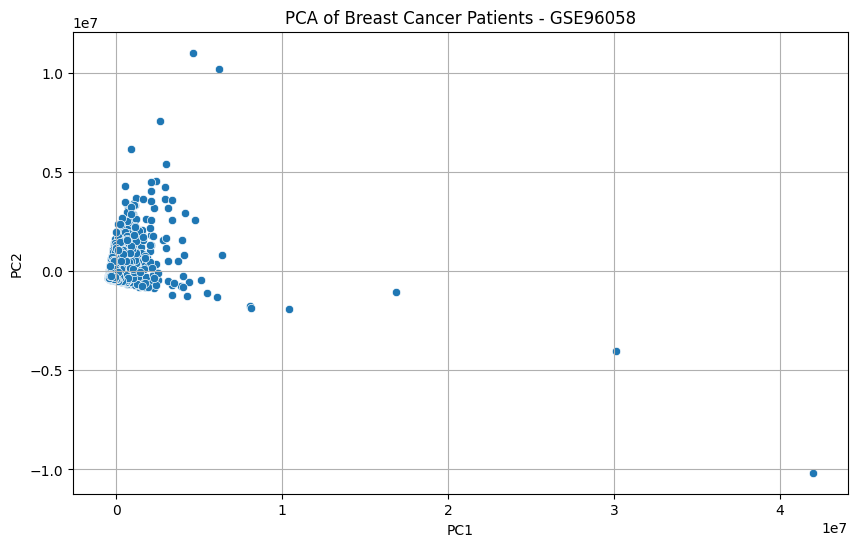

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Transpose: samples as rows, genes as columns
X = expr_df_main.T

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1])
plt.title("PCA of Breast Cancer Patients - GSE96058")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Patient Clusters')

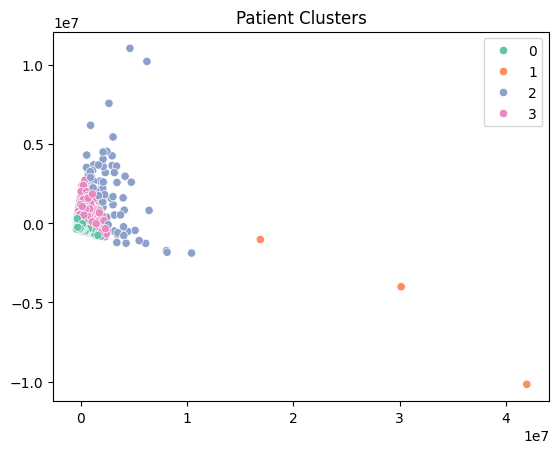

In [42]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Visualize
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="Set2")
plt.title("Patient Clusters")


C:\Program Files\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


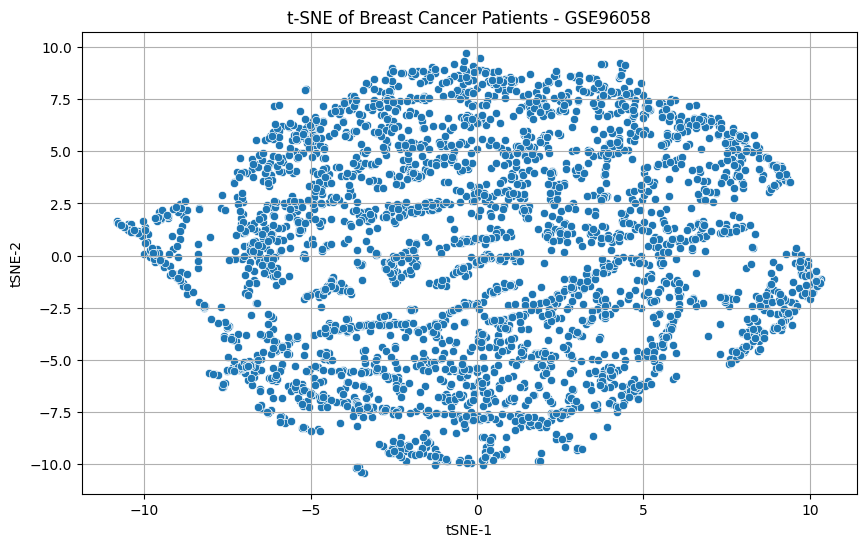

In [46]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1])
plt.title("t-SNE of Breast Cancer Patients - GSE96058")
plt.xlabel("tSNE-1")
plt.ylabel("tSNE-2")
plt.grid(True)
plt.show()


C:\Program Files\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


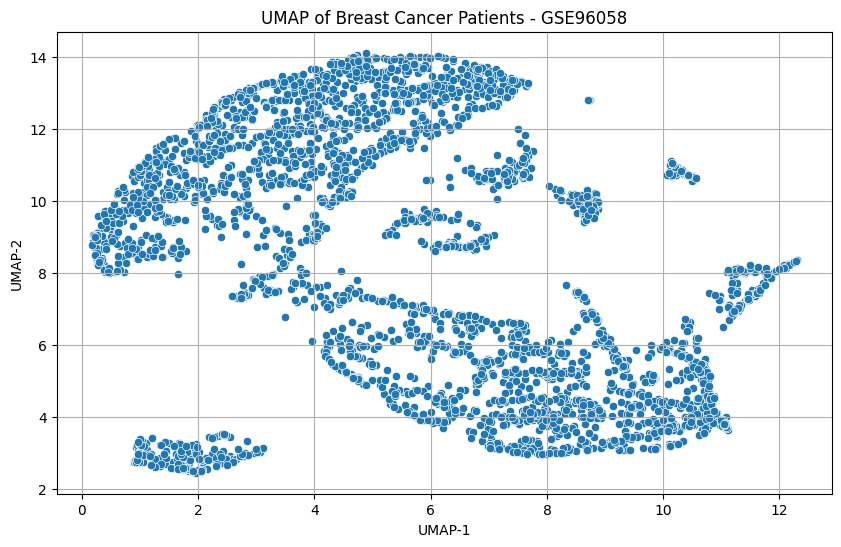

In [47]:
import umap.umap_ as umap

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1])
plt.title("UMAP of Breast Cancer Patients - GSE96058")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


In [61]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Load your data
df = pd.read_csv('breast_cancer_survival.csv', sep='\t')  # Adjust sep if needed

# Convert dates
df['Date_of_Surgery'] = pd.to_datetime(df['Date_of_Surgery'])
df['Date_of_Last_Visit'] = pd.to_datetime(df['Date_of_Last_Visit'])

# Calculate survival duration (days)
df['Survival_Days'] = (df['Date_of_Last_Visit'] - df['Date_of_Surgery']).dt.days

# Encode Patient_Status (Alive=0, Dead=1)
df['Patient_Status_bin'] = df['Patient_Status'].apply(lambda x: 1 if x=='Dead' else 0)

# Encode categorical variables if needed
for col in ['Gender', 'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status', 'Surgery_type']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Select features and target
features = ['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status', 'Surgery_type']
X = df[features]
y = df['Patient_Status_bin']

# Now you can build a classifier or survival model


KeyError: 'Date_of_Surgery'

In [62]:
df = pd.read_csv('breast_cancer_survival.csv')  # first try without sep param

print(df.columns.tolist())


['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status', 'Surgery_type', 'Date_of_Surgery', 'Date_of_Last_Visit', 'Patient_Status']


In [63]:
import pandas as pd

df = pd.read_csv('breast_cancer_survival.csv')  # no sep param
print(df.columns.tolist())

# Convert date columns
df['Date_of_Surgery'] = pd.to_datetime(df['Date_of_Surgery'])
df['Date_of_Last_Visit'] = pd.to_datetime(df['Date_of_Last_Visit'])

print(df[['Date_of_Surgery', 'Date_of_Last_Visit']].head())


['Age', 'Gender', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status', 'Surgery_type', 'Date_of_Surgery', 'Date_of_Last_Visit', 'Patient_Status']
  Date_of_Surgery Date_of_Last_Visit
0      2018-05-20         2018-08-26
1      2018-04-26         2019-01-25
2      2018-08-24         2020-04-08
3      2018-11-16         2020-07-28
4      2018-12-12         2019-01-05


C:\Users\hp\AppData\Local\Temp\ipykernel_26780\11512390.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date_of_Surgery'] = pd.to_datetime(df['Date_of_Surgery'])
C:\Users\hp\AppData\Local\Temp\ipykernel_26780\11512390.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date_of_Last_Visit'] = pd.to_datetime(df['Date_of_Last_Visit'])


In [64]:
# Calculate survival duration in days
df['Survival_Days'] = (df['Date_of_Last_Visit'] - df['Date_of_Surgery']).dt.days

# Convert Patient_Status to binary: Alive=0, Dead=1
df['Status_Binary'] = df['Patient_Status'].apply(lambda x: 1 if x == 'Dead' else 0)

print(df[['Survival_Days', 'Status_Binary']].head())


   Survival_Days  Status_Binary
0           98.0              0
1          274.0              1
2          593.0              0
3          620.0              0
4           24.0              0


In [66]:
!pip install lifelines


Defaulting to user installation because normal site-packages is not writeable
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4065 sha256=95021c8ffbb160ec49f03b73662233c84a35e360dd7015e30da4c7725bdc40d5
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\25\cc\e0\ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [67]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(df['Survival_Days'], event_observed=df['Status_Binary'])

kmf.plot_survival_function()
plt.title("Survival curve")
plt.xlabel("Days since surgery")
plt.ylabel("Survival probability")
plt.show()


TypeError: NaNs were detected in the dataset. Try using pd.isnull to find the problematic values.

In [68]:
print(df[df['Survival_Days'].isnull()])


     Age  Gender  Protein1  Protein2  Protein3  Protein4 Tumour_Stage  \
9     62  FEMALE  0.649340   1.81680  0.279260  0.132280           II   
18    46  FEMALE -0.010999   0.86749  0.281570 -0.545880           II   
60    56  FEMALE -0.675420   0.26937 -0.086603  1.071400          III   
105   69  FEMALE -0.757790  -0.33780  0.561410  0.208300           II   
117   88  FEMALE -0.603350   1.38250  0.403570  0.269210           II   
188   44  FEMALE -0.278840   2.16880 -0.462330  0.272200           II   
200   55  FEMALE  0.330640   0.84757 -0.494660  0.116560            I   
202   71  FEMALE  0.394090   1.70540  0.035642  1.441000           II   
206   47  FEMALE  0.515580   2.65020 -0.103130 -0.045725          III   
214   80  FEMALE  0.670770  -0.71039  0.186480  0.146640           II   
229   88  FEMALE -2.340900   0.37246  0.208450 -1.641100            I   
230   60  FEMALE  0.532420   1.54110 -1.009500 -0.125880            I   
231   50  FEMALE -0.322890   0.98848 -0.293130 -0.2

In [69]:
df = df.dropna(subset=['Survival_Days', 'Status_Binary'])
